**CSC 466: Knowledge Discovery in Data **
** Individual Test**

**Task 1 **

**Your Name **:

**Cal Poly Email**:

The program below performs hierarchical clustering using Complete Link distance.

**Your Task**: Perform the following:

  1. Add to the notebook the computation of the Centroid Distance method for computing the distance between two data points.
     The function getCentroid() is defined and stubbed below for your convenience
  
  2. Change the code of the hierarchical clustering function to use the Centroid distance.  
  
  3. Display the vector of cluster assignments constructed by function flatten()
  
  4. Plot the dataset colored by cluster (marking outliers with a separate color)
  
  5. Write a function computeClusterRadius(), which, given a cluster returns its radius.
  
  6. Report the radii for each cluster

**Notes:**

Please read carefully the comments to the existing code - they may explain things you need to know in order to complete some of the tasks.

I have created placeholders for the main functions you need to create and Jupyter cells at the bottom of the notebook for you to produce the desired output.  You may need/want/find it convenient to define additional functions, or to change the parameters in the function definitions provided to you. Feel free to do both/either as you see fit.

In [43]:
## Imports

import numpy as np
from matplotlib import pyplot as plt
import seaborn
%matplotlib inline

**Distance Metrics**

We use Eucledian distance between two points for this assignment. For simplicity, we declare our own function.

In [44]:
def eucledian(x,y):
    return np.sqrt(np.sum((x - y)*(x-y)))

** Complete Link Distance Computation **

The code below is simply to make the original Hierarchical code run.

In [45]:
## Parameters
## m: matrix of cluster distances
## i, j: clusters that are being merged (new cluster is {i,j})
## k: cluster to which the new distance needs to be computed

## complete link is the largest distance between two points belonging to two different clusters
## if a cluster i = {x1,...,xn} and cluster j = {y1,...,ym} are merged, then 
## the complete link distance from the new cluster ij = {x1,..,xn,y1,..,ym} to a cluster 
## k = {z1,...,zp} is the larger of the complete link distances between clusters k and i and clusters k and j

def completeLink(m, i,j,k):
    # assume i<j
    sim = min(m[i,k], m[j,k])
    
    return sim

**Your Assignment**: develop the centroidDistance() function in the cell below.

In [46]:
## Parameters
## data: the dataset (expect a numPy array or matrix)
## cluster1, cluster2 - dendrograms representing the two clusters 
## 
## Output: Centroid distance between the two clusters represented by the dendrograms.
## Note: leaf nodes in the dendrograms are indexes of points in the data array/matrix

def get_leaves(cluster):
    if len(cluster) == 1 and isinstance(cluster[0], list):
        return get_leaves(cluster[0])

    leaves = []
    for item in cluster[1:]:
        if len(item) == 1:
            leaves.extend(item)
        else:
            leaves.extend(get_leaves(item))

    return leaves

def centroidDistance(cluster1, cluster2, data):
    cl1_leaves = get_leaves(cluster1)
    cl2_leaves = get_leaves(cluster2)
    cl1 = data[cl1_leaves, :]
    cl2 = data[cl2_leaves, :]

    return eucledian(np.mean(cl1, axis=0), np.mean(cl2, axis=0))

** Compute Distance Matrix **

The computeDistanceMatrix() function below simply computes the pairwise distances between all data points.
To enable proper work of hierarchical, the distance between all pairs [i,i] is set to 'NaN'

This function is parameterized by the distance computation method. We are using Eucledian distance.

In [47]:
## Parameters
## data: numPy array of data points
## distanceMetric: name of the function for computing the distance between two data points

def computeDistanceMatrix(data, distanceMetric):
    ## size of distance matrix
    n = data.shape[0]
       
    distances = np.matrix([distanceMetric(x,y) for x in data for y in data]).reshape((n,n))
    
    for i in range(n):
        distances[i,i] = 'Nan'  # make sure that diagonal distances to not interfere with computation
    
    return distances

**Hierarchical Clustering**

The hierarchical clustering function hierarchical() below performs the hierarchical clustering using the hard-coded Complete Link distance between the clusters.

It creates a dendrogram of the clusters by starting with a list [[1],[2],[3]....[n]], where each element of the list represents a singleton cluster, and then, on every step merging the two clusters deemed closest to each other and labeling the merged cluster with the intercluster distance. 

For example, if clusters [1] and [2] in the list above have a distence 0.2, and this is the shortest intercluster distance, on the next step the list of clusters will look as follows:

        [[0.2, [1],[2]],[3],...,[n]]

** Your task:**
  Change the function hierarchical() to work with the centroid distance function you developed.A

In [48]:
## canonize() ensures that the values in the s= (i,j) pair satisfy i<j
def canonize(s):
    if s[0] < s[1]:
        return s
    else:
        return (s[1],s[0])

## Paremeters
## distances: matrix of distances
## data: the raw dataset. Passed in case needed for distance computations

def hierarchical(data, distances):
      
    size = distances.shape[0]
    m = np.matrix(np.copy(distances))  ## make a copy of the original distance matrix
                                       ## some distance computations may require it

    ## clusters is the data structure storing the dendrogram 
    clusters = [[i] for i in range(size)]    ## leaf level of the dendrogram
    
    for iteration in range(size-1):  ## we merge two clusters size-1 times
        
        s = np.unravel_index(np.nanargmin(m),m.shape)
        s = canonize(s)
    
        height = m[s[0],s[1]]  ## smallest distance between two clusters.
    
        clusters[s[0]] = [height, clusters[s[0]],clusters[s[1]]]   ## create a merged node in the
                                                                   ## dendrogram in-place 
    
        for i in range(m.shape[0]):
            if i != s[0] and i != s[1]:
                # newSim = completeLink(m, s[0],s[1],i)
                newSim = centroidDistance(clusters[s[0]], clusters[i], data)
                m[s[0],i] = newSim
                m[i,s[0]] = newSim
  
        ## modify data structures: delete row and column from the distance matrix
        ##                         delete merged entry from the dendrogram
        m= np.delete(m,s[1],0)
        m= np.delete(m,s[1],1)
        del clusters[s[1]]
    return clusters

** Cluster Output **

The functions below are used to process the dendrogram created by hierarchical() and to retrieve from this dendrogram the assignment of points to clusters.

getClusters() takes as input a dendrogram and a number of clusters, and produces as a result the list of dendrograms representing the requested number of clusters. 

**Note:** this method performs outlier removal - any singleton "clusters" detected during the process are removed

split() is the helper function for getClusters(), it finds, in a forest of dendrograms, the dendrogram with the highest height, and splits that dendrogram into two parts, performing outlier removal as needed.

flattenClusters() and its helper function flatten() work with the output produced by getClusters().  

flattenClusters() returns an array of cluster assignments - the value in position j represents the cluster label for the jth point in the dataset. If this value is -1, the point is an outlier. Cluster labels for k clusters are 0,1,.., k-1.

In [49]:
## Parameters
## clusters: the dendrogram from Hierarchical clustering method
## k: number of clusters to extract

def split(clusters):
    
    size = len(clusters)
    
    maxHeight = clusters[0][0]
    idx = 0
    for i in range(size):
        if clusters[i][0] > maxHeight:
            maxHeight = clusters[i][0]
            idx = i
    s = clusters[idx]
    left = s[1]
    right = s[2]
    l = []
    if len(left)==3:     ## check if leaf
        l.append(left)
    if len(right)==3:
        l.append(right)
    del clusters[idx]
    clusters.extend(l)
    
    return clusters
                
    
def getClusters(clusters, k):

    s = clusters
    while len(clusters) < k:
        s = split(s)
       
    return s
    
def flatten(cluster, assignment, label):
    left = cluster[1]
    right = cluster[2]
    if len(left)== 3:
        flatten(left, assignment,label)
    else:
        assignment[left[0]] = label
    if len(right) == 3:
        flatten(right,assignment, label)
    else:
        assignment[right[0]]= label
    
    return
        
    

## takes the output of getClusters() function and assigns a cluster label to each data label
## n: number of data points in the dataset
def flattenClusters(clusters,n):   

    k = len(clusters)  ## number of clusters.
    
    assignment = np.full((n), -1)
    
    for i in range(k):
        flatten(clusters[i], assignment,i)
    
    return assignment
    


** Reading in the Dataset **


In [50]:
filename = "data1.csv"

rawData = np.loadtxt(filename, delimiter = ",")

## let's keep only the two columns with the data attributes

data = rawData[:,0:2]


**Let's visualize the dataset**

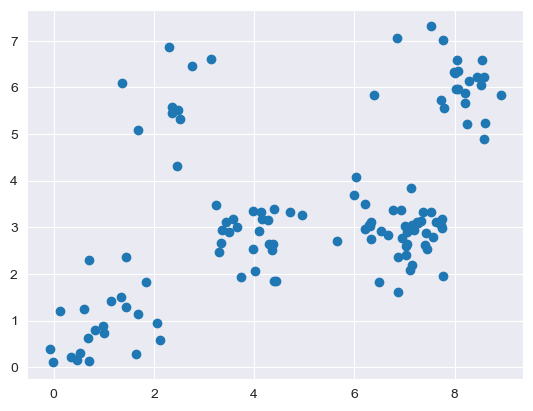

In [51]:
plt.scatter(data[:,0],data[:,1])

In [52]:
## Perform Clustering

distanceMatrix = computeDistanceMatrix(data, eucledian)
clusters = hierarchical(data,distanceMatrix)

C:\Users\hsu_m\anaconda3\envs\csc466\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\hsu_m\anaconda3\envs\csc466\lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


**Your Task**: output the cluster assignment. 

We are looking for **five (5)** clusters

** Your Task**: visualize the scatterplot of your cluster assignments

In [53]:
flattenClusters(getClusters(clusters, 5), data.shape[0])

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [54]:
## Use the array of colors below.  Use black for outliers, other colors for the five clusters you constructed.

colors=['black', 'blue', 'green', 'red', 'purple', 'brown']


In [55]:
cmapping = [colors[i+1] for i in flattenClusters(getClusters(clusters, 5), data.shape[0])]
cmapping

['blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'purple',
 'purple',
 'purple',
 'purple',
 'purple',
 'purple',
 'purple',
 'purple',
 'purple',
 'purple',
 'purple',
 'purple',
 'purple',
 'purple',
 'purple',
 'purple',
 'purple',
 'purple',
 'purple',
 'purple',
 'purple',
 'purple',
 'green',
 'purple',
 'purple',
 'purple',
 'purple',
 'purple',
 'purple',
 'purple',
 'purple',
 'purple',
 'purple',
 'purple',
 'purple',
 'purple',
 'purple',
 'purple',
 'purple',
 'purple',
 'purple',
 'purple',
 'purple',
 'purple',
 'purple',
 'purple',
 'purple',
 'purple',
 'purple',
 'purple',
 'purple',
 'purple',
 'purple',
 'purple',
 'purple',
 'purple',
 'purple',
 'purple',
 'purple',
 'purple',
 'purple',
 'purple',
 'purple',
 'brown',
 'purple',
 'purple',
 'green',
 'green',
 'green',
 'green',
 'green',
 'green',
 'green',
 'green'

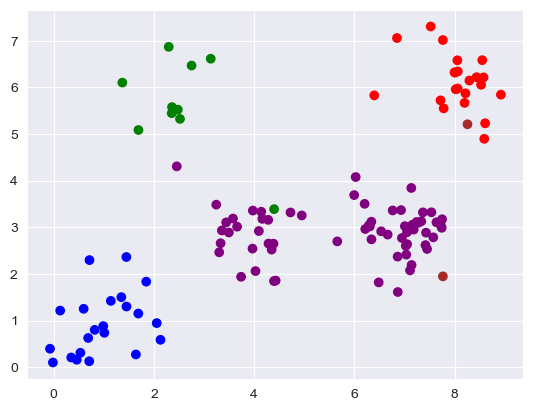

In [56]:
plt.scatter(data[:,0],data[:,1], c=cmapping)


**When you are done**: download the notebook, submit using the following command:

        handin dekhtyar 466-test <notebook>